In [47]:
import os
import requests
import gzip
import shutil
from typing import Optional, Union, Tuple, List
from dataclasses import dataclass, field

import causallift
from causallift import CausalLift

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

causallift.__version__
pd.options.display.max_rows = 8
seed = 42

In [2]:
def prepare_data(data: str, **kwargs):

    if data == 'simulated_observational_data':
        """
        # Generate simulated data
        # "Sleeping dogs" (a.k.a. "do-not-disturb"; people who will "buy" if not 
        treated but will not "buy" if treated) can be simulated by negative values 
        in tau parameter.
        # Observational data which includes confounding can be simulated by 
        non-zero values in propensity_coef parameter.  
        # A/B Test (RCT) with a 50:50 split can be simulated by all-zeros values 
        in propensity_coef parameter (default).
        # The first element in each list parameter specifies the intercept.
        """
        from causallift import generate_data

        np.random.seed(seed)

        df = generate_data(
            N=20000, 
            n_features=3, 
            beta=[0, -2, 3, -5], # Effect of [intercept and features] on outcome 
            error_std=0.1, 
            tau=[1, -5, -5, 10], # Effect of [intercept and features] on treated outcome
            tau_std=0.1, 
            discrete_outcome=True, 
            seed=seed, 
            feature_effect=0, # Effect of beta on treated outcome
            propensity_coef=[0, -1, 1, -1], # Effect of [intercept and features] on propensity log-odds for treatment
            index_name='index',
        )
        
    elif data == 'lalonde':
        r""" 
            Lalonde dataset was used to evaluate propensity score in the paper:
            Dehejia, R., & Wahba, S. (1999). Causal Effects in Nonexperimental 
            Studies: Reevaluating the Evaluation of Training Programs. Journal of 
            the American Statistical Association, 94(448), 1053-1062. 
            doi:10.2307/2669919

            Lalonde dataset is now included in R package named "Matching."
            http://sekhon.berkeley.edu/matching/lalonde.html
        """
        def get_lalonde():
            r""" Load datasets, concatenate, and create features to get data frame 
            similar to 'lalonde' that comes with "Matching.")
            """
            cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
            control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep=r'\s+', header = None, names = cols)
            treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep=r'\s+', header = None, names = cols)
            lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
            lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
            lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
            return lalonde_df
        lalonde_df = get_lalonde()
        
        """ Prepare the input Data Frame. """
        df = lalonde_df.copy()
        df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
        df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
        
        # categorize age to 20s, 30s, 40s, and 50s and then one-hot encode age
        df.loc[:,'age'] = df['age'].apply(lambda x:'{:.0f}'.format(x)[:-1]+'0s') 
        df = pd.get_dummies(df, columns=['age'], drop_first=True) 
        
        cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 
                'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
        df = df[cols]

    elif data == 'criteo':
        save_dir = "./raw_data"
        os.makedirs(save_dir, exist_ok=True)

        criteo_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
        zip_file_name = "raw_data/criteo-research-uplift-v2.1.csv.gz"
        unzip_file_name = "raw_data/criteo-research-uplift-v2.1.csv"
        
        if os.path.isfile(unzip_file_name):
            print("The downloaded file already exists!")
        
        else:
            print("Try to download the raw data from the server...")
            response = requests.get(criteo_url, stream=True)
            total_size_in_bytes = int(response.headers.get("content-length", 0))
            block_size = 1024
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(zip_file_name, "wb") as f:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    f.write(data)
            progress_bar.close()
            print("Finished downloading!!!")
            if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                print("Error, something went wrong!")
                return

            print("Try to unzip the downloaded file")
            with gzip.open(zip_file_name, "rb") as f_in:
                with open (unzip_file_name, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

            os.remove(zip_file_name)
            print("Zip file removed from disk")

        print("Import the csv file into pd.DataFrame")
        df = pd.read_csv(unzip_file_name)
    
    else:
        raise ValueError("No corresponding data found")

    return df

In [3]:
df = prepare_data("simulated_observational_data")

In [4]:
np.sum(df["Treatment"] == 1)/len(df)
# 15% is treated

0.3859

In [5]:
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_df), len(eval_df))

16000 4000


In [6]:
train_df.head()

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
index,,,,,
5894,0.705646,0.118903,0.591185,1.0,0.0
3728,0.671304,0.990192,0.090662,0.0,1.0
8958,0.048870,0.596951,0.643174,0.0,0.0
7671,0.790777,0.159311,0.252047,0.0,0.0
5999,0.725692,0.692031,0.821540,1.0,0.0


In [7]:
corr = train_df.corr()
corr

,Feature_0,Feature_1,Feature_2,Treatment,Outcome
Feature_0,1.000000,-0.005264,-0.003518,-0.133840,-0.415703
Feature_1,-0.005264,1.000000,0.000265,0.123293,0.103306
Feature_2,-0.003518,0.000265,1.000000,-0.139524,-0.042754
Treatment,-0.133840,0.123293,-0.139524,1.000000,0.322685
Outcome,-0.415703,0.103306,-0.042754,0.322685,1.000000


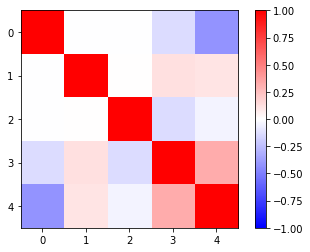

In [8]:
plt.imshow(corr, cmap="bwr")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

In [9]:
pd.crosstab(train_df["Treatment"], train_df["Outcome"])/len(train_df)

Outcome,0.0,1.0
Treatment,,
0.0,0.553188,0.062875
1.0,0.241937,0.142000


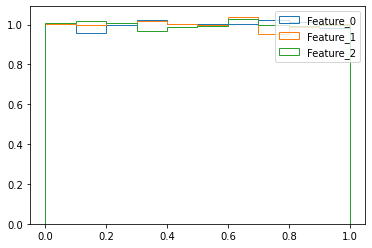

In [10]:
for idx, column in enumerate(df.columns):
    if idx >= len(df.columns) - 2:
        # t and y varaibles
        continue
    plt.hist(df[column], density=True, histtype="step", label=column)
plt.legend()

In [11]:
class UpliftDataset(Dataset): 
    def __init__(
        self,
        df: pd.DataFrame, 
        in_features: int,
        t_idx: Optional[int] = None, 
        y_idx: Optional[int] = None,
    ):
        t_idx = in_features if t_idx is None else t_idx
        y_idx = in_features + 1 if y_idx is None else y_idx

        self.in_features = in_features
        self.t_idx = t_idx
        self.y_idx = y_idx

        self.df = df
        self.X = self.df.iloc[:, 0:in_features]
        self.t = self.df.iloc[:, t_idx]
        self.y = self.df.iloc[:, y_idx]

    def __len__(self): 
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X.iloc[idx, :].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.t.iloc[idx], dtype=torch.float32)
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32)
        return (X, t, y)

In [12]:
num_features = 3

train_set = UpliftDataset(train_df, num_features)
eval_set  = UpliftDataset(eval_df, num_features)

train_dl = DataLoader(train_set, batch_size=128, shuffle=True)
eval_dl  = DataLoader(eval_set, batch_size=128, shuffle=False)

In [13]:
train_set[0]

(tensor([0.7056, 0.1189, 0.5912]), tensor(1.), tensor(0.))

In [14]:
class ComplexModel(nn.Module): 
    def __init__(
        self,
        in_features: int,
    ):
        super().__init__()
        self.expand = nn.Linear(in_features+1, 128)
        self.fc1 = nn.Linear(128, 128) 
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128) 
        self.bn2 = nn.BatchNorm1d(128)
        self.classifier = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):

        x = self.expand(x)
        _x = torch.tanh(self.bn1(self.fc1(x))) 
        x = self.dropout(_x) + x
        _x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout(_x) + x
        x = self.classifier(x)
        return x

In [15]:
train_set[0]
class UpliftWrapper(nn.Module): 
    def __init__(
        self,
        in_features: int,
    ):
        super(UpliftWrapper, self).__init__() 
        self.in_features = in_features 
        self.model = ComplexModel(in_features) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(
        self, 
        x: torch.Tensor, 
        t: torch.Tensor,
    ):
        """Forward function for Uplift model
        Args:
            x: `torch.Tensor`
            t: `torch.Tensor`
        Returns:
            `dict[str, torch.Tensor]`
        """
        # X shape: (B, N)
        if t.ndim == 2:
            t = t.squeeze()
        B = x.size(0)
        L = x.size(1)
        # print(f"input shape: {x.shape}")
        
        # first creating the inputs accordingly
        x_0 = torch.cat([x, torch.zeros([B, 1]).to(x.device)], dim=1) 
        x_1 = torch.cat([x, torch.ones([B, 1]).to(x.device)], dim=1)

        y_0 = self.sigmoid(self.model(x_0)).squeeze()
        y_1 = self.sigmoid(self.model(x_1)).squeeze()
        
        pred = torch.where(t == 1, y_1, y_0)
        return {
            "uplift": y_1 - y_0, "pred": pred,
        }

In [16]:
class DirectUpliftLoss(nn.Module): 
    def __init__(self,
        propensity_score: float = 0.5,
        alpha: Optional[float] = None, 
    ):
        super(DirectUpliftLoss, self).__init__()
        if alpha > 1 or alpha < 0:
            raise ValueError("alpha must be in [0, 1]")
        self.e_x = propensity_score 
        self.alpha = alpha

        self.loss_u = nn.MSELoss() 
        self.loss_y = nn.BCELoss()

    def forward(self, out, t, y):
        z = t * y / self.e_x - (1-t) * y / (1-self.e_x) 
        # variable transformation
        
        loss_uplift = self.loss_u(out["uplift"], z) 
        loss_pred = self.loss_y(out["pred"], y)
        loss = (1-self.alpha) * loss_uplift + self.alpha * loss_pred 
        
        return loss

In [17]:
model = UpliftWrapper(num_features)
criterion = DirectUpliftLoss(0.5, 0.8)

In [18]:
train_set[0][0].unsqueeze(0)

tensor([[0.7056, 0.1189, 0.5912]])

In [19]:
model.eval()
out = model(train_set[0][0].unsqueeze(0), train_set[0][1])
out

{'uplift': tensor(0.0785, grad_fn=<SubBackward0>),
 'pred': tensor(0.5525, grad_fn=<SWhereBackward>)}

In [20]:
X, t, y = next(iter(train_dl))
out = model(X, t)
# print(out)
# print(out["uplift"].shape, out["pred"].shape)

In [21]:
out["pred"].shape, out["uplift"].shape

(torch.Size([128]), torch.Size([128]))

(array([ 3.,  9., 18., 13., 16., 16., 12., 18., 15.,  8.]),
 array([0.07436967, 0.07497504, 0.0755804 , 0.07618576, 0.07679113,
        0.0773965 , 0.07800186, 0.07860723, 0.07921259, 0.07981796,
        0.08042333], dtype=float32),
 <BarContainer object of 10 artists>)

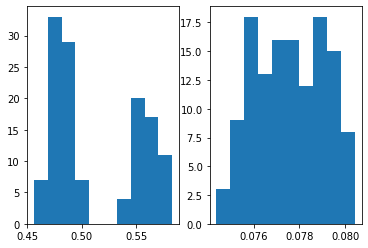

In [22]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(out["pred"].detach().cpu().numpy())
ax[1].hist(out["uplift"].detach().cpu().numpy())

In [23]:
# loss = criterion(out, t, y)
loss = criterion(out, t, y)
loss

tensor(0.6500, grad_fn=<AddBackward0>)

In [24]:
z = t * y / 0.5 - (1-t) * y / (1-0.5)
z

tensor([ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., -2.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0., -2.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.])

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

In [33]:
model.cuda()

num_epochs = 20
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}")

    train_answ = []
    train_pred = []

    model.train()
    for X, t, y in tqdm(train_dl):
        optimizer.zero_grad()
        train_answ.extend(y.numpy().tolist())

        X = X.cuda()
        t = t.cuda()
        y = y.cuda()

        out = model(X, t)
        loss = criterion(out, t, y)
        # loss = criterion(out["pred"], y)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        pred = np.where(out["pred"].detach().cpu().numpy() > 0.5, 1, 0)
        train_pred.extend(pred.tolist())

    train_answ = np.array(train_answ)
    train_pred = np.array(train_pred)

    train_accuracies.append(np.sum(train_answ == train_pred)/len(train_answ))
    print(f"train accuracy: {train_accuracies[-1]}, train f1: {f1_score(train_answ, train_pred)}")

    eval_cnt = 0
    eval_corrects = 0

    model.eval()
    with torch.no_grad():

        eval_answ = []
        eval_pred = []
        eval_prob = []

        for X, t, y in eval_dl:
            eval_cnt += X.size(0)
            eval_answ.extend(y.numpy().tolist())

            X = X.cuda()
            t = t.cuda()
            y = y.cuda()

            out = model(X, t)
            loss = criterion(out, t, y)
            # loss = criterion(out["pred"], y)
            eval_losses.append(loss.item())

            prob = out["pred"].detach().cpu().numpy()
            eval_prob.extend(prob.tolist())
            pred = np.where(prob > 0.5, 1, 0)
            eval_pred.extend(pred.tolist())

    eval_answ = np.array(eval_answ)
    eval_pred = np.array(eval_pred)
    eval_prob = np.array(eval_prob)

    eval_accuracies.append(np.sum(eval_answ == eval_pred)/len(eval_answ))
    print(f"eval accuracy: {eval_accuracies[-1]}, eval f1: {f1_score(eval_answ, eval_pred)}")

    print()


  4%|▍         | 5/125 [00:00<00:02, 48.66it/s]

epoch: 0


 19%|█▉        | 6/32 [00:00<00:00, 59.30it/s]

train accuracy: 0.8828125, train f1: 0.6778903968390311


  4%|▍         | 5/125 [00:00<00:02, 48.09it/s]

eval accuracy: 0.86125, eval f1: 0.6185567010309279

epoch: 1


 19%|█▉        | 6/32 [00:00<00:00, 58.45it/s]

train accuracy: 0.882375, train f1: 0.6781805745554036


  4%|▍         | 5/125 [00:00<00:02, 48.96it/s]

eval accuracy: 0.815, eval f1: 0.45022288261515603

epoch: 2


 19%|█▉        | 6/32 [00:00<00:00, 58.61it/s]

train accuracy: 0.8876875, train f1: 0.6927679945289792


  4%|▍         | 5/125 [00:00<00:02, 45.18it/s]

eval accuracy: 0.81825, eval f1: 0.4289080911233307

epoch: 3


 19%|█▉        | 6/32 [00:00<00:00, 57.35it/s]

train accuracy: 0.884, train f1: 0.6787815853236414


  4%|▍         | 5/125 [00:00<00:02, 42.24it/s]

eval accuracy: 0.815, eval f1: 0.41362916006339145

epoch: 4


 19%|█▉        | 6/32 [00:00<00:00, 59.32it/s]

train accuracy: 0.8815625, train f1: 0.6757912745936698


  4%|▍         | 5/125 [00:00<00:02, 49.00it/s]

eval accuracy: 0.845, eval f1: 0.6163366336633663

epoch: 5


 19%|█▉        | 6/32 [00:00<00:00, 58.78it/s]

train accuracy: 0.88675, train f1: 0.6921508664627931


  4%|▍         | 5/125 [00:00<00:02, 47.80it/s]

eval accuracy: 0.804, eval f1: 0.38170347003154576

epoch: 6


 19%|█▉        | 6/32 [00:00<00:00, 58.10it/s]

train accuracy: 0.8849375, train f1: 0.685137677441423


  4%|▍         | 5/125 [00:00<00:02, 45.80it/s]

eval accuracy: 0.80075, eval f1: 0.37879968823070925

epoch: 7


 19%|█▉        | 6/32 [00:00<00:00, 57.25it/s]

train accuracy: 0.88525, train f1: 0.6895502198173824


  4%|▍         | 5/125 [00:00<00:02, 46.47it/s]

eval accuracy: 0.80825, eval f1: 0.4131599081866871

epoch: 8


 19%|█▉        | 6/32 [00:00<00:00, 51.71it/s]

train accuracy: 0.88425, train f1: 0.6876897133220912


  4%|▍         | 5/125 [00:00<00:02, 48.51it/s]

eval accuracy: 0.824, eval f1: 0.5014164305949008

epoch: 9


 19%|█▉        | 6/32 [00:00<00:00, 57.38it/s]

train accuracy: 0.883625, train f1: 0.6839782756279702


  4%|▍         | 5/125 [00:00<00:02, 47.48it/s]

eval accuracy: 0.821, eval f1: 0.48191027496382055

epoch: 10


 19%|█▉        | 6/32 [00:00<00:00, 51.17it/s]

train accuracy: 0.88425, train f1: 0.6853550798504927


  4%|▍         | 5/125 [00:00<00:02, 41.13it/s]

eval accuracy: 0.8285, eval f1: 0.5127840909090909

epoch: 11


 19%|█▉        | 6/32 [00:00<00:00, 58.31it/s]

train accuracy: 0.8845, train f1: 0.6865671641791046


  4%|▍         | 5/125 [00:00<00:02, 43.87it/s]

eval accuracy: 0.8375, eval f1: 0.5927318295739349

epoch: 12


 19%|█▉        | 6/32 [00:00<00:00, 58.78it/s]

train accuracy: 0.8850625, train f1: 0.6902475997978778


  4%|▍         | 5/125 [00:00<00:02, 47.18it/s]

eval accuracy: 0.845, eval f1: 0.5844504021447722

epoch: 13


 19%|█▉        | 6/32 [00:00<00:00, 58.02it/s]

train accuracy: 0.888375, train f1: 0.7006369426751593


  4%|▍         | 5/125 [00:00<00:02, 49.66it/s]

eval accuracy: 0.8015, eval f1: 0.348111658456486

epoch: 14


 19%|█▉        | 6/32 [00:00<00:00, 58.52it/s]

train accuracy: 0.8834375, train f1: 0.6828770617241965


  4%|▍         | 5/125 [00:00<00:02, 45.18it/s]

eval accuracy: 0.81925, eval f1: 0.45516201959306707

epoch: 15


 19%|█▉        | 6/32 [00:00<00:00, 56.16it/s]

train accuracy: 0.8854375, train f1: 0.6906329113924051


  4%|▍         | 5/125 [00:00<00:02, 49.01it/s]

eval accuracy: 0.8265, eval f1: 0.5091937765205092

epoch: 16


 19%|█▉        | 6/32 [00:00<00:00, 58.74it/s]

train accuracy: 0.8865625, train f1: 0.6922163812107852


  4%|▍         | 5/125 [00:00<00:02, 49.21it/s]

eval accuracy: 0.7945, eval f1: 0.39736070381231675

epoch: 17


 19%|█▉        | 6/32 [00:00<00:00, 57.62it/s]

train accuracy: 0.8846875, train f1: 0.6901763224181361


  4%|▍         | 5/125 [00:00<00:02, 47.68it/s]

eval accuracy: 0.807, eval f1: 0.3412969283276451

epoch: 18


 19%|█▉        | 6/32 [00:00<00:00, 58.83it/s]

train accuracy: 0.888375, train f1: 0.6953258273626748


  4%|▍         | 5/125 [00:00<00:02, 46.88it/s]

eval accuracy: 0.80275, eval f1: 0.44631578947368417

epoch: 19


 19%|█▉        | 6/32 [00:00<00:00, 58.28it/s]

train accuracy: 0.8839375, train f1: 0.6878466969238527


100%|██████████| 32/32 [00:00<00:00, 57.91it/s]

eval accuracy: 0.802, eval f1: 0.36129032258064514



(array([18.,  2.,  2.,  4.,  2.,  0.,  0.,  3.,  1.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

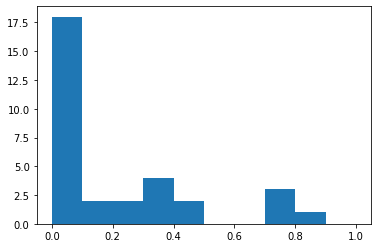

In [34]:
plt.hist(out["pred"].detach().cpu().numpy(), bins=np.arange(0, 1.1, 0.1))

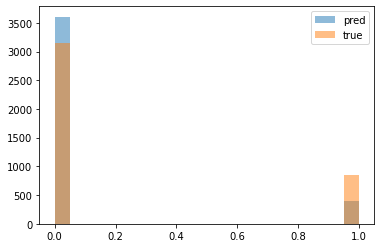

In [36]:
plt.hist(eval_pred, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="pred")
plt.hist(eval_answ, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label="true")
plt.legend()
plt.show()

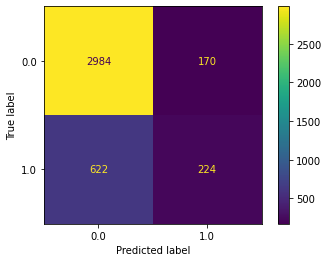

In [37]:
ConfusionMatrixDisplay.from_predictions(eval_answ, eval_pred)

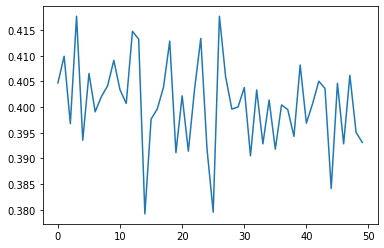

In [38]:
n_size = 50
length = (len(train_losses) // n_size) * n_size
plt.plot(np.array(train_losses[-length:]).reshape(-1, n_size).mean(axis=1))

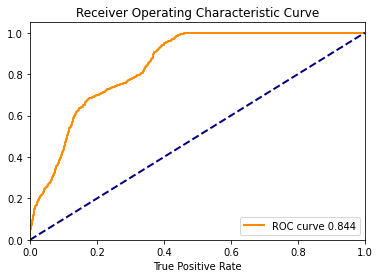

In [50]:
fpr, tpr, _ = roc_curve(eval_answ, eval_prob)
auc = roc_auc_score(eval_answ, eval_prob)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve %.3f" % (auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()